In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt
from scipy.stats import norm, t

# Ensure plots are displayed in the notebook
%matplotlib inline


In [2]:
def getData(stocks, start, end):
    """
    Fetch stock data from Yahoo Finance, compute log returns, mean returns, and covariance matrix.

    Parameters:
    stocks (list): List of stock tickers.
    start (str): Start date in 'YYYY-MM-DD' format.
    end (str): End date in 'YYYY-MM-DD' format.

    Returns:
    returns (DataFrame): Log returns of the stocks.
    meanReturns (Series): Mean log returns of the stocks.
    covMatrix (DataFrame): Covariance matrix of the log returns.
    """
    stockData = yf.download(stocks, start=start, end=end)
    stockData = stockData['Close']  # Use only the closing prices
    returns = np.log(stockData / stockData.shift(1))  # Calculate log returns
    meanReturns = returns.mean()  # Calculate mean returns
    covMatrix = returns.cov()  # Calculate covariance matrix
    return returns, meanReturns, covMatrix


In [3]:
# Define stock list and date range
stockList = ['HAL', 'BEL', 'ASTRAMICRO', 'PREMEXPLN', 'SOLARINDS', 'BEML', 'MTARTECH', 'CYIENT', 'LT', 'INDIGO']
tickers = [stock + '.NS' for stock in stockList]  # Append '.NS' for NSE stocks

# Fetch stock data
stocks_data = yf.download(tickers, start=dt.datetime(2021, 3, 15), end=dt.datetime(2023, 6, 30))
stocks_data = stocks_data['Close']  # Use only the closing prices

# Normalize prices for comparison
stock_normed = stocks_data / stocks_data.iloc[0]
stock_daily_ret = stocks_data.pct_change(1)  # Daily returns

# Calculate log returns
log_ret = np.log(stocks_data / stocks_data.shift(1))


[*********************100%%**********************]  10 of 10 completed


In [4]:
stocks_data

Ticker,ASTRAMICRO.NS,BEL.NS,BEML.NS,CYIENT.NS,HAL.NS,INDIGO.NS,LT.NS,MTARTECH.NS,PREMEXPLN.NS,SOLARINDS.NS
Date,,,,,,,,,,
2021-03-15,134.949997,45.700001,1139.823364,668.200012,508.000000,1661.949951,1483.750000,1082.500000,31.549999,1324.250000
2021-03-16,131.149994,45.950001,1160.120117,702.049988,535.700012,1682.099976,1461.800049,1008.049988,30.879999,1322.400024
2021-03-17,133.000000,44.616665,1158.393677,673.500000,523.025024,1695.550049,1437.650024,950.349976,30.440001,1304.449951
2021-03-18,127.199997,43.266666,1100.450806,660.849976,515.424988,1719.949951,1428.099976,920.700012,29.540001,1279.599976
2021-03-19,137.350006,42.650002,1130.811890,660.099976,516.025024,1663.599976,1411.250000,969.450012,29.799999,1291.599976
...,...,...,...,...,...,...,...,...,...,...
2023-06-22,384.399994,123.449997,1622.900024,1490.800049,1880.224976,2476.949951,2416.250000,1962.650024,87.800003,3832.600098
2023-06-23,367.950012,120.050003,1629.300049,1460.300049,1820.275024,2475.050049,2389.550049,1916.849976,86.220001,3746.050049
2023-06-26,364.250000,121.400002,1572.800049,1459.699951,1850.525024,2464.850098,2377.550049,1941.300049,87.559998,3753.199951


In [5]:
# Define number of portfolios to simulate
num_ports = 10_000_000

# Initialize arrays to store portfolio metrics
all_weights = np.zeros((num_ports, len(stocks_data.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

# Generate random portfolios and compute metrics
for ind in range(num_ports):
    weights = np.random.random(len(tickers))  # Random weights
    weights = weights / np.sum(weights)  # Normalize weights

    all_weights[ind, :] = weights  # Save weights

    # Calculate expected return and standard deviation
    ret_arr[ind] = np.sum((log_ret.mean() * weights) * 252)  # Annualized return
    vol_arr[ind] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))  # Annualized volatility
    sharpe_arr[ind] = ret_arr[ind] / vol_arr[ind]  # Sharpe Ratio


In [6]:
# Find the optimal portfolio with the highest Sharpe Ratio
optimal_ret = ret_arr[sharpe_arr.argmax()]
optimal_vol = vol_arr[sharpe_arr.argmax()]
optiman_weights = all_weights[sharpe_arr.argmax()]
print("Optimal Return: ", optimal_ret)
print("Optimal Volatility: ", optimal_vol)
print("Optimal Weights: ", optiman_weights)


Optimal Return:  0.4613966427762035
Optimal Volatility:  0.20732165340722397
Optimal Weights:  [0.05116149 0.03469777 0.00515237 0.16618895 0.31802468 0.00147766
 0.05033513 0.01664601 0.13151162 0.22480431]


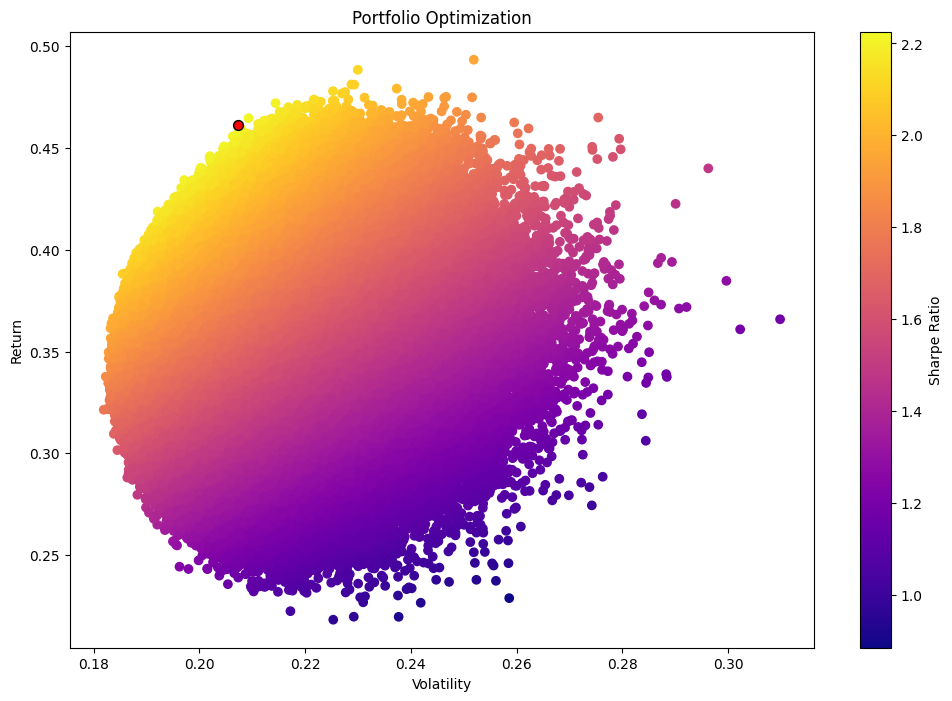

In [7]:
# Plot the Efficient Frontier
plt.figure(figsize=(12, 8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='plasma')  # Color by Sharpe Ratio
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(optimal_vol, optimal_ret, c='red', s=50, edgecolors='black')  # Highlight optimal portfolio
plt.title('Portfolio Optimization')
plt.savefig('Port_optimisation.png', bbox_inches='tight')  # Save the plot


In [8]:
def portfolioPerformance(weights, meanReturns, covMatrix, Time):
    """
    Compute the portfolio's return and standard deviation.

    Parameters:
    weights (array): Weights of the portfolio.
    meanReturns (Series): Mean returns of the stocks.
    covMatrix (DataFrame): Covariance matrix of the returns.
    Time (int): Time horizon (e.g., 1 for daily).

    Returns:
    returns (float): Expected portfolio return.
    std (float): Portfolio standard deviation.
    """
    returns = np.sum(meanReturns * weights) * Time
    std = np.sqrt(np.dot(weights.T, np.dot(covMatrix, weights))) * np.sqrt(Time)
    return returns, std


In [10]:
# Compute portfolio performance metrics
returns, meanReturns, covMatrix = getData(tickers, start=dt.datetime(2023, 7, 1), end=dt.datetime.now())
returns = returns.dropna()  # Drop any missing values
GMV_weights = all_weights[vol_arr.argmin()]  # Global Minimum Variance weights
weights = GMV_weights
returns['Portfolio'] = returns.dot(weights)  # Portfolio returns

alpha = 5  # Confidence level for VaR and CVaR calculations


[*********************100%%**********************]  10 of 10 completed


In [11]:
weights

array([0.00535738, 0.08690644, 0.07796052, 0.10713443, 0.04099004,
       0.08369275, 0.33195293, 0.02188273, 0.08885367, 0.15526911])

In [12]:
def historicalVaR(returns, alpha=5):
    """
    Compute Historical Value at Risk (VaR).

    Parameters:
    returns (Series): Portfolio returns.
    alpha (float): Confidence level.

    Returns:
    VaR (float): Value at Risk at the specified confidence level.
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historicalVaR, alpha=alpha)
    else:
        raise TypeError('Expected returns to be dataframe or series')

def historicalCVaR(returns, alpha=5):
    """
    Compute Historical Conditional Value at Risk (CVaR).

    Parameters:
    returns (Series): Portfolio returns.
    alpha (float): Confidence level.

    Returns:
    CVaR (float): Conditional Value at Risk at the specified confidence level.
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= historicalVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()
    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historicalCVaR, alpha=alpha)
    else:
        raise TypeError('Expected returns to be dataframe or series')


In [13]:
# Calculate VaR and CVaR using the historical method
Time = 365  # Time horizon (1 day)
VaR = -historicalVaR(returns['Portfolio'], alpha=alpha)
CVaR = -historicalCVaR(returns['Portfolio'], alpha=alpha)
pRet, pStd = portfolioPerformance(weights, meanReturns, covMatrix, Time)
pRet
print(f"This portfolio has an expected return of {(pRet * 100)}% for the last one year")

This portfolio has an expected return of 94.44978573577978% for the last one year


<h3>Let us find how much we would have gained if we invested Rs 10,000 on 1st July 2023 </h3>

In [14]:
# Fetch stock data
stocks_data = yf.download(tickers, start=dt.datetime(2023,7,1), end=dt.datetime.now())
stocks_data = stocks_data['Close']  # Use only the closing prices

# Normalize prices for comparison
stock_normed = stocks_data / stocks_data.iloc[0]
stock_daily_ret = stocks_data.pct_change(1)  # Daily returns

[*********************100%%**********************]  10 of 10 completed


In [15]:
# Calculate daily log returns
log_ret = np.log(stocks_data / stocks_data.shift(1))

In [16]:
# Use the optimal weights calculated earlier
optiman_weights = all_weights[sharpe_arr.argmax()]  # Ensure this is the optimal weights array from previous code

# Calculate portfolio returns using the optimal weights
portfolio_returns = log_ret.dot(optiman_weights)

In [17]:
# Initial investment
initial_investment = 10000  # Rs10,000

# Calculate the portfolio value over time
portfolio_value = initial_investment * np.exp(portfolio_returns.cumsum())
portfolio_value


Date
2023-07-03             NaN
2023-07-04     9949.664393
2023-07-05     9974.194063
2023-07-06    10014.990248
2023-07-07    10024.677966
                  ...     
2024-08-19    24844.899262
2024-08-20    25129.135791
2024-08-21    25045.103768
2024-08-22    25009.181270
2024-08-23    25215.698627
Length: 281, dtype: float64

In [18]:
# Calculate the final portfolio value
final_value = portfolio_value[-1]  # Value at the end of the period

# Calculate the total return
total_return = final_value - initial_investment

# Print results
print(f"Initial Investment: Rs. {initial_investment}")
print(f"Final Portfolio Value: Rs. {final_value:.2f}")
print(f"Total Return: Rs. {total_return:.2f}")
print(f"Total Return Percentage: {((final_value / initial_investment) - 1) * 100:.2f}%")


Initial Investment: Rs. 10000
Final Portfolio Value: Rs. 25215.70
Total Return: Rs. 15215.70
Total Return Percentage: 152.16%


C:\Users\SANDIPAN\AppData\Local\Temp\ipykernel_7036\1086824833.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  final_value = portfolio_value[-1]  # Value at the end of the period


<h3> Our portfolio gives a total return of 152.16% which is more than HDFC Defence Fund, which gives a total return of 125.64% in the same time interval. Thus, our portfolio outperforms HDFC Defence Fund </h3>